In [1]:
import pandas as pd
from core.analysis import *

<Figure size 432x288 with 0 Axes>

## Data Prep

In [2]:
db = access_db()
trials = get_trial_data(db)
participants = get_participant_data(db)

In [3]:
user_data = participants[(participants['completedTask'] == 1) & (participants.index > 4) 
                         & ~(participants['workerID'].str.startswith("pilot"))] #excluding my data/Jon/Stephan
results = trials[trials['userID'].isin(user_data['userID'])]
users = user_data['userID']

## MDS

In [11]:
all_shared_defs = display_sense_definitions(results, 'shared')

,Sense,Type,Definition
212,foot_n_01,foot_n,the part of the leg of a human being below the ankle joint
213,foot_n_02,foot_n,a linear unit of length equal to 12 inches or a third of a yard
214,foot_n_03,foot_n,the lower part of anything


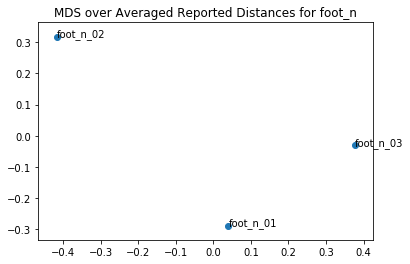

In [12]:
plot_individual_mds(results, 'foot_n', 'shared', users, db, all_shared_defs)

,Sense,Type,Definition
215,table_n_01,table_n,a set of data arranged in rows and columns
216,table_n_02,table_n,a piece of furniture having a smooth flat top that is usually supported by one or more vertical legs
217,table_n_03,table_n,a piece of furniture with tableware for a meal laid out on it


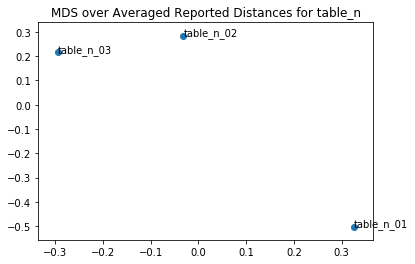

In [13]:
plot_individual_mds(results, 'table_n', 'shared', users, db, all_shared_defs)

,Sense,Type,Definition
218,airplane_n_01,plane_n,an aircraft that has a fixed wing and is powered by propellers or jets
219,plane_n_02,plane_n,(mathematics) an unbounded two-dimensional shape
220,plane_n_03,plane_n,a level of existence or development


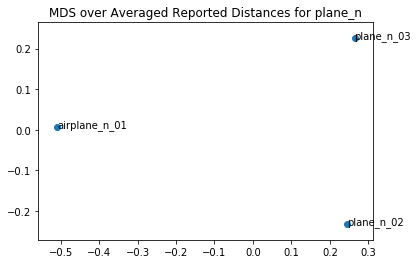

In [14]:
plot_individual_mds(results, 'plane_n', 'shared', users, db, all_shared_defs)

,Sense,Type,Definition
221,academic_degree_n_01,degree_n,an award conferred by a college or university signifying that the recipient has satisfactorily completed a course of study
222,degree_n_01,degree_n,a position on a scale of intensity or amount or quality
223,degree_n_02,degree_n,a specific identifiable position in a continuum or series or especially in a process


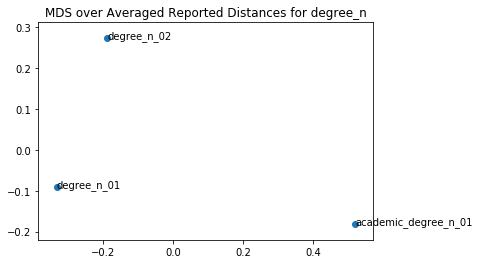

In [15]:
plot_individual_mds(results, 'degree_n', 'shared', users, db, all_shared_defs)

,Sense,Type,Definition
224,right_n_01,right_n,an abstract idea of that which is due to a person or governmental body by law or tradition or nature; ; - Eleanor Roosevelt
225,right_n_02,right_n,location near or direction toward the right side; i.e. the side to the south when a person or object faces east
226,right_n_04,right_n,those who support political or social or economic conservatism; those who believe that things are better left unchanged


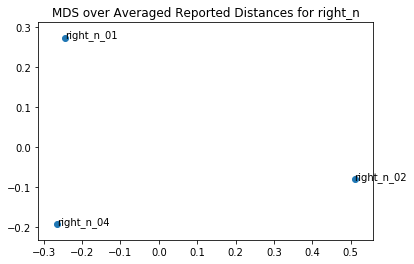

In [16]:
plot_individual_mds(results, 'right_n', 'shared', users, db, all_shared_defs)

,Sense,Type,Definition
227,model_n_01,model_n,a hypothetical description of a complex entity or process
228,model_n_02,model_n,a type of product
229,model_n_03,model_n,a person who poses for a photographer or painter or sculptor


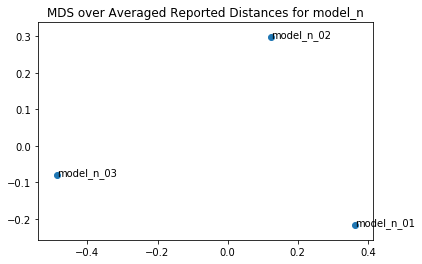

In [17]:
plot_individual_mds(results, 'model_n', 'shared', users, db, all_shared_defs)

## Consistency

In [18]:
repeat_corr = all_repeats(results, users, plot = False) #self correlation
shared_results = results[results['trialType'] == 'shared']
shared_corrs = group_consistency(shared_results, users) #shared correlation
user_time_word_changes = get_time_and_changes(results, user_data) #metadata
consistency = pd.DataFrame({'Group Consistency': shared_corrs, 'Self Consistency': repeat_corr})
corrs = user_time_word_changes.merge(consistency, on = user_time_word_changes.index).drop('key_0', axis = 1)
corrs['Correlation with SN'] = my_correlations(participants, trials, results, users) #vs gold standard

In [16]:
corrs.drop('userID', axis = 1).apply(np.mean)

timeTaken              692.897357
changes                  6.964286
Group Consistency        0.512886
Self Consistency         0.549777
Correlation with SN      0.509483
dtype: float64

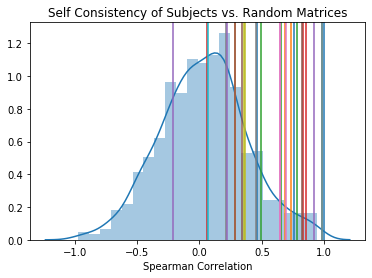

In [19]:
random_self = simulate_self_correlation(1000, db)
plot_consistency_hist(random_self, corrs['Self Consistency'], 
                      "Self Consistency of Subjects vs. Random Matrices", legend = False)

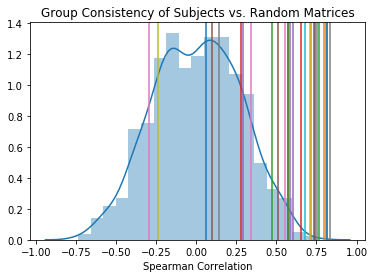

In [20]:
random_group = [random_vs_all(shared_results) for _ in range(1000)]
plot_consistency_hist(random_group, corrs['Group Consistency'], 
                      "Group Consistency of Subjects vs. Random Matrices", legend = False)

Exclusion criteria: Self below 0.3?